# VGG19 Transfer Learning을 활용한 꽃 이미지 분류 프로젝트

이 노트북은 VGG19 사전학습 모델을 사용한 **인라인 방식**의 Transfer Learning으로 5가지 꽃 종류를 분류하는 다중 분류 프로젝트입니다.

## 프로젝트 개요
- **목표**: VGG19 사전학습 모델을 활용한 5가지 꽃 종류 분류
- **방법**: Transfer Learning (인라인 방식)
- **클래스**: Daisy, Dandelion, Rose, Sunflower, Tulip (5개)
- **데이터**: Flowers 데이터셋
- **프레임워크**: TensorFlow/Keras

## 이진 분류 vs 다중 분류

### 🌸 다중 분류 (이 프로젝트)
- **클래스 수**: 5개 (daisy, dandelion, rose, sunflower, tulip)
- **출력층**: Dense(5, activation="softmax")
- **손실 함수**: sparse_categorical_crossentropy
- **라벨 형태**: 정수형 (0, 1, 2, 3, 4)

### 🐱🐶 이진 분류 (이전 프로젝트)
- **클래스 수**: 2개 (cat, dog)
- **출력층**: Dense(1, activation="sigmoid")
- **손실 함수**: binary_crossentropy
- **라벨 형태**: 확률값 (0~1)

## 프로젝트 구조
1. 라이브러리 임포트 및 데이터 탐색
2. 데이터 전처리 및 분할
3. VGG19 인라인 모델 구축
4. 모델 학습 및 저장
5. 결과 분석 및 시각화


## 1. 라이브러리 임포트 및 환경 설정

필요한 라이브러리들을 임포트하고 데이터셋의 기본 정보를 확인합니다.


In [2]:
# 딥러닝 관련 라이브러리
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import load_model 
from keras import models, layers
from keras.applications.vgg19 import VGG19
from keras.utils import image_dataset_from_directory

# 데이터 처리 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import pickle
import random

# 파일 시스템 관련 라이브러리
import os
import shutil
import imghdr
from pathlib import Path

print("라이브러리 임포트 완료!")
print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")

# 경고 메시지 제거 (선택사항)
import warnings
warnings.filterwarnings('ignore')


라이브러리 임포트 완료!
TensorFlow 버전: 2.15.1
Keras 버전: 2.15.0


In [4]:
# 데이터셋 경로 설정 및 기본 정보 확인
base_path = "../../data/flowers/train"

print("🌸 Flowers 데이터셋 기본 정보:")
print("=" * 50)

# 각 클래스별 이미지 개수 확인
flower_classes = ["daisy", "dandelion", "sunflower", "rose", "tulip"]
total_images = 0

for flower_class in flower_classes:
    class_path = os.path.join(base_path, flower_class)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        total_images += count
        print(f"📁 {flower_class.capitalize():>10}: {count:>4}개 이미지")
    else:
        print(f"❌ {flower_class} 폴더를 찾을 수 없습니다!")

print("=" * 50)
print(f"📊 총 이미지 수: {total_images}개")
print(f"🏷️ 클래스 수: {len(flower_classes)}개")
print(f"📈 클래스당 평균: {total_images // len(flower_classes)}개")

# 클래스 라벨링 정보
print(f"\n🏷️ 클래스 라벨 매핑 (알파벳 순서):")
sorted_classes = sorted(flower_classes)
for i, class_name in enumerate(sorted_classes):
    print(f"   {i}: {class_name}")

print("\n✅ 데이터셋 탐색 완료!")


🌸 Flowers 데이터셋 기본 정보:
📁      Daisy:  501개 이미지
📁  Dandelion:  646개 이미지
📁  Sunflower:  495개 이미지
📁       Rose:  497개 이미지
📁      Tulip:  607개 이미지
📊 총 이미지 수: 2746개
🏷️ 클래스 수: 5개
📈 클래스당 평균: 549개

🏷️ 클래스 라벨 매핑 (알파벳 순서):
   0: daisy
   1: dandelion
   2: rose
   3: sunflower
   4: tulip

✅ 데이터셋 탐색 완료!


## 2. 데이터 전처리 및 분할

꽃 이미지 데이터셋을 모델 학습에 적합한 형태로 전처리하고 Train/Validation/Test로 분할합니다.

### 전처리 과정:
1. **이미지 리네이밍**: `class_name.index.ext` 형식으로 통일 (예: `daisy.0.jpg`)
2. **데이터 분할**: Train(50%) / Validation(25%) / Test(25%) 비율로 분할
3. **폴더 구조 생성**: 케라스 `image_dataset_from_directory`에 적합한 구조

### 최종 폴더 구조:
```
flowers_small/
├── train/
│   ├── daisy/      # 라벨: 0
│   ├── dandelion/  # 라벨: 1  
│   ├── rose/       # 라벨: 2
│   ├── sunflower/  # 라벨: 3
│   └── tulip/      # 라벨: 4
├── validation/
│   └── (동일한 구조)
└── test/
    └── (동일한 구조)
```

**중요**: 케라스는 폴더 이름을 **알파벳 순서**로 정렬하여 자동 라벨링합니다!


In [5]:
def rename_images_in_class_folder(src_class_dir, class_name, dest_dir):
    """
    특정 클래스 폴더의 이미지들을 'class_name.인덱스.확장자' 형식으로 리네이밍
    
    Args:
        src_class_dir: 원본 클래스 폴더 경로
        class_name: 클래스명 (예: 'daisy')
        dest_dir: 리네이밍된 이미지가 저장될 폴더
    """
    os.makedirs(dest_dir, exist_ok=True)

    # 이미지 파일만 필터링
    files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    files.sort()

    for idx, fname in enumerate(files):
        src_path = os.path.join(src_class_dir, fname)
        ext = os.path.splitext(fname)[1].lower()
        new_name = f"{class_name}.{idx}{ext}"
        dst_path = os.path.join(dest_dir, new_name)
        shutil.copyfile(src_path, dst_path)

    print(f"✅ {class_name} 리네임 완료: {len(files)}개 처리됨.")


def rename_all_classes(original_root_dir, renamed_root_dir):
    """
    모든 클래스의 이미지들을 리네이밍하여 하나의 폴더에 통합
    
    Args:
        original_root_dir: 원본 데이터셋 폴더 (클래스별 하위 폴더 포함)
        renamed_root_dir: 리네이밍된 이미지들이 저장될 폴더
    """
    classes = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

    # 기존 폴더가 있으면 삭제 후 새로 생성
    if os.path.exists(renamed_root_dir):
        shutil.rmtree(renamed_root_dir)
    os.makedirs(renamed_root_dir, exist_ok=True)

    for class_name in classes:
        src_class_dir = os.path.join(original_root_dir, class_name)
        rename_images_in_class_folder(src_class_dir, class_name, renamed_root_dir)

print("이미지 리네이밍 함수 정의 완료!")


이미지 리네이밍 함수 정의 완료!


In [6]:
def copy_images_by_class(class_name, original_dataset_dir, dest_dirs, split_ratio=(0.5, 0.25, 0.25)):
    """
    특정 클래스의 이미지들을 Train/Validation/Test로 분할 복사
    
    Args:
        class_name: 클래스명
        original_dataset_dir: 리네이밍된 이미지들이 있는 폴더
        dest_dirs: [train_dir, val_dir, test_dir] 리스트
        split_ratio: 분할 비율 (기본값: 50:25:25)
    """
    # 해당 클래스의 이미지 파일들 찾기
    image_files = [
        f for f in os.listdir(original_dataset_dir)
        if f.startswith(f"{class_name}.") and f.lower().endswith(('.jpg', '.jpeg', '.png')) 
        and os.path.isfile(os.path.join(original_dataset_dir, f))
    ]
    image_files.sort()
    random.shuffle(image_files)  # 랜덤 셔플

    # 분할 인덱스 계산
    total = len(image_files)
    train_end = int(total * split_ratio[0])
    val_end = train_end + int(total * split_ratio[1])

    # 분할된 파일 리스트
    splits = [image_files[:train_end], image_files[train_end:val_end], image_files[val_end:]]

    # 각 세트로 파일 복사
    for split, dst_dir in zip(splits, dest_dirs):
        os.makedirs(dst_dir, exist_ok=True)
        for fname in split:
            src = os.path.join(original_dataset_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copyfile(src, dst)


def ImageCopy(renamed_dataset_dir, base_dir):
    """
    리네이밍된 이미지들을 Train/Validation/Test 폴더로 분할하여 복사
    
    Args:
        renamed_dataset_dir: 리네이밍된 이미지들이 있는 폴더
        base_dir: Train/Val/Test 폴더들이 생성될 기본 경로
    """
    categories = ["daisy", "dandelion", "rose", "sunflower", "tulip"]
    sets = ["train", "validation", "test"]

    # 기존 폴더 삭제 후 새로 생성
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    for set_name in sets:
        for category in categories:
            os.makedirs(os.path.join(base_dir, set_name, category), exist_ok=True)

    # 폴더 경로 설정
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "validation")
    test_dir = os.path.join(base_dir, "test")

    # 각 클래스별로 이미지 분할 복사
    for category in categories:
        print(f"🔄 {category} 분할 중...")
        copy_images_by_class(
            class_name=category,
            original_dataset_dir=renamed_dataset_dir,
            dest_dirs=[
                os.path.join(train_dir, category),
                os.path.join(val_dir, category),
                os.path.join(test_dir, category)
            ],
            split_ratio=(0.5, 0.25, 0.25)
        )

    print("\n✅ 이미지 분할 복사 완료!\n")

    # 결과 요약 출력
    for set_name in sets:
        for category in categories:
            dir_path = os.path.join(base_dir, set_name, category)
            count = len(os.listdir(dir_path))
            print(f"📁 {set_name}/{category}: {count}개")

print("데이터 분할 함수 정의 완료!")


데이터 분할 함수 정의 완료!


In [8]:
# 데이터 전처리 실행
print("🔄 꽃 이미지 데이터 전처리 시작...\n")

# 경로 설정
original_dataset_dir = "../../data/flowers/train"           # 원본 데이터셋 폴더 (클래스별 하위 폴더 있음)
renamed_root = "../../data/flowers_renamed"           # 리네이밍된 이미지들이 저장될 위치
base_dir = "../../data/flowers_small"                 # 최종 분할된 train/val/test 폴더 생성 위치

print(f"📁 경로 설정:")
print(f"   원본 데이터: {original_dataset_dir}")
print(f"   리네이밍 저장: {renamed_root}")
print(f"   분할 저장: {base_dir}")

print("\n" + "="*60)
print("1단계: 클래스별 이미지들을 daisy.0.jpg 형식으로 리네임 + 통합")
print("="*60)
rename_all_classes(original_dataset_dir, renamed_root)

print("\n" + "="*60)
print("2단계: 리네이밍된 이미지를 50:25:25 비율로 train/validation/test 분할 복사")
print("="*60)
ImageCopy(renamed_root, base_dir)

print("\n✅ 모든 데이터 전처리 완료!")


🔄 꽃 이미지 데이터 전처리 시작...

📁 경로 설정:
   원본 데이터: ../../data/flowers/train
   리네이밍 저장: ../../data/flowers_renamed
   분할 저장: ../../data/flowers_small

1단계: 클래스별 이미지들을 daisy.0.jpg 형식으로 리네임 + 통합
✅ daisy 리네임 완료: 501개 처리됨.
✅ dandelion 리네임 완료: 646개 처리됨.
✅ rose 리네임 완료: 497개 처리됨.
✅ sunflower 리네임 완료: 495개 처리됨.
✅ tulip 리네임 완료: 607개 처리됨.

2단계: 리네이밍된 이미지를 50:25:25 비율로 train/validation/test 분할 복사
🔄 daisy 분할 중...
🔄 dandelion 분할 중...
🔄 rose 분할 중...
🔄 sunflower 분할 중...
🔄 tulip 분할 중...

✅ 이미지 분할 복사 완료!

📁 train/daisy: 250개
📁 train/dandelion: 323개
📁 train/rose: 248개
📁 train/sunflower: 247개
📁 train/tulip: 303개
📁 validation/daisy: 125개
📁 validation/dandelion: 161개
📁 validation/rose: 124개
📁 validation/sunflower: 123개
📁 validation/tulip: 151개
📁 test/daisy: 126개
📁 test/dandelion: 162개
📁 test/rose: 125개
📁 test/sunflower: 125개
📁 test/tulip: 153개

✅ 모든 데이터 전처리 완료!


In [9]:
# 데이터셋 로더 생성
base_dir = Path(base_dir)

print("📁 데이터셋 로더 생성 중...")

# batch_size에 지정된 만큼 폴더로부터 이미지를 읽어옵니다
# image_size에 지정한 크기로 자동 리사이징됩니다
# 케라스는 폴더명을 알파벳 순서로 정렬하여 자동 라벨링합니다

train_ds = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=16,
    label_mode='int'  # 다중 분류용 정수 라벨
)

validation_ds = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=16,
    label_mode='int'
)

test_ds = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=16,
    label_mode='int'
)

print("✅ 데이터셋 로더 생성 완료!")

# 클래스 이름 및 라벨 매핑 확인
class_names = train_ds.class_names
print(f"\n🏷️ 클래스 정보:")
print(f"   클래스 이름: {class_names}")
print(f"   클래스 수: {len(class_names)}개")

print(f"\n📊 라벨 매핑 (알파벳 순서):")
for i, class_name in enumerate(class_names):
    print(f"   {i}: {class_name}")

print(f"\n📁 데이터셋 정보:")
print(f"   Train: {train_ds}")
print(f"   Validation: {validation_ds}")
print(f"   Test: {test_ds}")


📁 데이터셋 로더 생성 중...
Found 1371 files belonging to 5 classes.
Found 684 files belonging to 5 classes.
Found 691 files belonging to 5 classes.
✅ 데이터셋 로더 생성 완료!

🏷️ 클래스 정보:
   클래스 이름: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
   클래스 수: 5개

📊 라벨 매핑 (알파벳 순서):
   0: daisy
   1: dandelion
   2: rose
   3: sunflower
   4: tulip

📁 데이터셋 정보:
   Train: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
   Validation: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
   Test: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## 3. VGG19 인라인 모델 구축 (다중 분류)

VGG19 사전학습 모델을 사용하여 5가지 꽃을 분류하는 다중 분류 모델을 구축합니다.

### 다중 분류 모델의 특징:
- **출력층**: Dense(5, activation="softmax") - 5개 클래스 확률 출력
- **손실 함수**: sparse_categorical_crossentropy - 정수 라벨 다중 분류
- **라벨 형태**: 정수 (0: daisy, 1: dandelion, 2: rose, 3: sunflower, 4: tulip)

### 모델 구조:
```
입력 이미지 (180x180x3)
    ↓
데이터 증강 (RandomFlip, RandomRotation, RandomZoom)
    ↓
VGG19 전처리 (ImageNet 정규화)
    ↓
VGG19 CNN (동결) → 특성 추출 (5x5x512)
    ↓
Flatten → Dense(256) → Dense(128) → Dense(64) → Dense(5, softmax)
```

### 이진 분류 vs 다중 분류 비교:

| 구분 | 이진 분류 (개-고양이) | 다중 분류 (꽃 5종) |
|------|---------------------|-------------------|
| **클래스 수** | 2개 | 5개 |
| **출력층** | Dense(1, sigmoid) | Dense(5, softmax) |
| **손실 함수** | binary_crossentropy | sparse_categorical_crossentropy |
| **라벨 형태** | 0 또는 1 | 0, 1, 2, 3, 4 |
| **출력 해석** | 확률값 (0~1) | 각 클래스별 확률 분포 |


In [12]:
def create_flower_classification_model():
    """
    VGG19를 사용한 꽃 분류 인라인 모델 생성
    
    Returns:
        keras.Model: 컴파일된 다중 분류 모델
    """
    print("🔧 VGG19 사전학습 모델 로드 중...")
    
    # VGG19 사전학습 모델 로드
    conv_base = keras.applications.vgg19.VGG19(
        weights="imagenet",        # ImageNet 가중치 사용
        include_top=False,         # 상단 분류층 제외 (CNN 부분만)
        input_shape=(180, 180, 3)  # 입력 크기 지정
    )
    
    print("📊 VGG19 모델 정보:")
    print(f"   입력 크기: {conv_base.input_shape}")
    print(f"   출력 크기: {conv_base.output_shape}")
    
    # VGG19 가중치 동결 확인
    conv_base.trainable = True
    print(f"   동결 전 훈련 가능한 가중치: {len(conv_base.trainable_weights)}개")
    
    conv_base.trainable = False  # VGG19 가중치 동결
    print(f"   동결 후 훈련 가능한 가중치: {len(conv_base.trainable_weights)}개")
    print("✅ VGG19 가중치 동결 완료!")
    
    # 데이터 증강 레이어 정의
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),      # 수평 뒤집기
        layers.RandomRotation(0.2),          # ±20% 회전
        layers.RandomZoom(0.4),              # ±40% 확대/축소
    ], name="data_augmentation")
    
    print("🔄 데이터 증강 레이어 정의 완료!")
    
    # 전체 모델 구축
    print("🏗️ 인라인 모델 구축 중...")
    
    inputs = keras.Input(shape=(180, 180, 3), name="input_layer")
    
    # 1. 데이터 증강 적용
    x = data_augmentation(inputs)
    
    # 2. VGG19 전처리 (ImageNet 정규화)
    x = keras.applications.vgg19.preprocess_input(x)
    
    # 3. VGG19 특성 추출 (동결된 상태)
    x = conv_base(x)
    
    # 4. 분류 네트워크 (다중 분류용)
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(256, activation="relu", name="dense_256")(x)
    x = layers.Dense(128, activation="relu", name="dense_128")(x)
    x = layers.Dense(64, activation="relu", name="dense_64")(x)
    outputs = layers.Dense(5, activation="softmax", name="output_5_classes")(x)  # 5개 클래스 softmax
    
    # 모델 생성
    model = keras.Model(inputs, outputs, name="VGG19_Flower_Classifier")
    
    # 모델 컴파일 (다중 분류용 설정)
    model.compile(
        loss="sparse_categorical_crossentropy",  # 정수 라벨 다중 분류
        optimizer="adam",                       # Adam 옵티마이저
        metrics=["accuracy"]
    )
    
    print("✅ 꽃 분류 인라인 모델 구축 완료!")
    return model

# 모델 생성
model = create_flower_classification_model()

# VGG19 구조 간략 확인
print("\n📋 VGG19 구조 요약 (마지막 몇 개 레이어):")
#conv_base.summary()

print("\n📋 전체 모델 구조:")
model.summary()


🔧 VGG19 사전학습 모델 로드 중...
📊 VGG19 모델 정보:
   입력 크기: (None, 180, 180, 3)
   출력 크기: (None, 5, 5, 512)
   동결 전 훈련 가능한 가중치: 32개
   동결 후 훈련 가능한 가중치: 0개
✅ VGG19 가중치 동결 완료!
🔄 데이터 증강 레이어 정의 완료!
🏗️ 인라인 모델 구축 중...
✅ 꽃 분류 인라인 모델 구축 완료!

📋 VGG19 구조 요약 (마지막 몇 개 레이어):

📋 전체 모델 구조:
Model: "VGG19_Flower_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 180, 180, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 180, 180, 3)       0         
 ial)                                                            
                                                                 
 tf.__operators__.getitem_2  (None, 180, 180, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 180, 1

## 4. 모델 학습 및 저장

구축된 꽃 분류 모델을 학습시키고 최적 모델을 자동 저장합니다.

### 학습 설정:
- **에포크**: 10회 반복 학습
- **데이터**: 원본 이미지에 실시간 증강 적용
- **콜백**: ModelCheckpoint로 최적 모델 자동 저장
- **모니터링**: 검증 손실(val_loss) 기준으로 최적 모델 선정
- **저장 파일**: `꽃.keras` (모델), `꽃.bin` (학습 기록)

### 다중 분류 모델 학습의 특징:
1. **Softmax 출력**: 5개 클래스의 확률 분포 출력
2. **Sparse Categorical Crossentropy**: 정수 라벨에 최적화된 손실 함수
3. **클래스별 성능**: 각 꽃 종류별로 정확도가 다를 수 있음
4. **과적합 방지**: 데이터 증강으로 일반화 성능 향상


In [14]:
def train_flower_model(model, train_ds, validation_ds, epochs=10):
    """
    꽃 분류 모델 학습 함수
    
    Args:
        model: 컴파일된 keras 모델
        train_ds: 훈련 데이터셋
        validation_ds: 검증 데이터셋
        epochs: 학습 에포크 수
        
    Returns:
        history: 학습 기록
    """
    print("🚀 꽃 분류 모델 학습 시작...")
    print(f"   에포크: {epochs}회")
    print(f"   클래스: {len(train_ds.class_names)}개 (다중 분류)")
    print("   ※ 인라인 방식은 시간이 오래 걸릴 수 있습니다.")
    
    # 콜백 설정 (최적 모델 자동 저장)
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="꽃_weights.h5",        # 가중치 저장 경로
            save_weights_only=True,          # 가중치만 저장 (직렬화 오류 방지)
            save_best_only=True,             # 최고 성능 모델만 저장
            monitor="val_accuracy",          # 검증 정확도 기준
            mode='max',                      # 최대값 기준
            verbose=1                        # 저장 시 메시지 출력
        )
    ]
    
    # 모델 학습
    history = model.fit(
        train_ds,                        # 훈련 데이터
        epochs=epochs,                   # 에포크 수
        validation_data=validation_ds,   # 검증 데이터
        callbacks=callbacks,             # 콜백 함수
        verbose=1                        # 학습 과정 출력
    )
    
    print("✅ 모델 학습 완료!")
    
    # 학습 기록 저장
    with open("꽃.bin", "wb") as file:
        pickle.dump(history.history, file)
    print("💾 학습 기록 저장 완료: 꽃.bin")
    
    # 최종 성능 출력
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n📊 최종 학습 결과:")
    print(f"   훈련 정확도: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   검증 정확도: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   훈련 손실: {final_train_loss:.4f}")
    print(f"   검증 손실: {final_val_loss:.4f}")
    
    return history

# 모델 학습 실행
print("="*70)
print("🌸 꽃 분류 모델 학습 시작")
print("="*70)

history = train_flower_model(model, train_ds, validation_ds, epochs=10)

print("\n" + "="*70)
print("✅ 꽃 분류 모델 학습 완료!")
print("="*70)


🌸 꽃 분류 모델 학습 시작
🚀 꽃 분류 모델 학습 시작...
   에포크: 10회
   클래스: 5개 (다중 분류)
   ※ 인라인 방식은 시간이 오래 걸릴 수 있습니다.
Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.7469
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to 꽃_weights.h5

Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to 꽃_weights.h5
86/86 [==============================] - 100s 1s/step - loss: 0.8515 - accuracy: 0.7469 - val_loss: 0.8556 - val_accuracy: 0.7778
Epoch 2/10
86/86 [==============================] - 100s 1s/step - loss: 0.8515 - accuracy: 0.7469 - val_loss: 0.8556 - val_accuracy: 0.7778
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7666
Epoch 2: val_accuracy improved from 0.77778 to 0.80994, saving model to 꽃_weights.h5

Epoch 2: val_accuracy improved from 0.77778 to 0.80994, saving model to 꽃_weights.h5
86/86 [==============================] - 96s 1s/step - loss: 0.7062 - accuracy: 0.7666 - val_loss: 0.6544 - 

## 5. 결과 분석 및 시각화

학습 과정과 결과를 시각화하고 다중 분류 모델의 성능을 분석합니다.


📈 꽃 분류 모델 학습 과정 시각화:


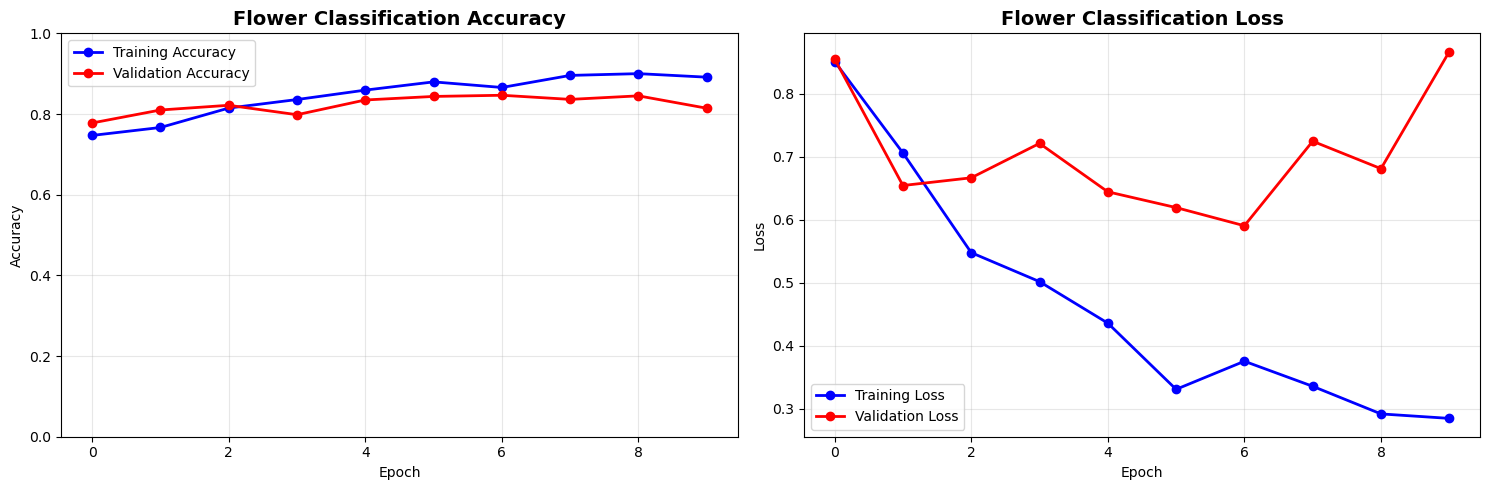

📊 다중 분류 모델 최종 성능:
   훈련 정확도: 0.8913 (89.13%)
   검증 정확도: 0.8143 (81.43%)
   훈련 손실: 0.2844
   검증 손실: 0.8671
✅ 적절한 학습이 이루어졌습니다.


In [16]:
def plot_flower_training_results(history):
    """
    꽃 분류 모델의 학습 과정을 시각화
    
    Args:
        history: model.fit()에서 반환된 History 객체 또는 딕셔너리
    """
    if history is None:
        print("❌ 학습 기록이 없습니다.")
        return
    
    # history 객체에서 딕셔너리 추출
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 정확도 그래프
    ax1.plot(hist_dict['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
    ax1.plot(hist_dict['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
    ax1.set_title('Flower Classification Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # 손실 그래프
    ax2.plot(hist_dict['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=6)
    ax2.plot(hist_dict['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=6)
    ax2.set_title('Flower Classification Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 최종 성능 출력
    final_train_acc = hist_dict['accuracy'][-1]
    final_val_acc = hist_dict['val_accuracy'][-1]
    final_train_loss = hist_dict['loss'][-1]
    final_val_loss = hist_dict['val_loss'][-1]
    
    print("📊 다중 분류 모델 최종 성능:")
    print(f"   훈련 정확도: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   검증 정확도: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   훈련 손실: {final_train_loss:.4f}")
    print(f"   검증 손실: {final_val_loss:.4f}")
    
    # 과적합 분석
    if final_train_acc - final_val_acc > 0.1:
        print("⚠️ 과적합이 감지되었습니다. 더 많은 데이터 증강이나 정규화가 필요할 수 있습니다.")
    else:
        print("✅ 적절한 학습이 이루어졌습니다.")

# 학습 결과 시각화
if 'history' in locals() and history is not None:
    print("📈 꽃 분류 모델 학습 과정 시각화:")
    plot_flower_training_results(history)
else:
    print("ℹ️ 학습 기록을 시각화하려면 먼저 모델을 학습하세요.")


In [17]:
def evaluate_flower_model_on_test(model_path="꽃_weights.h5"):
    """
    저장된 꽃 분류 모델을 로드하여 테스트 데이터로 평가
    
    Args:
        model_path: 저장된 가중치 파일 경로
    """
    try:
        # 모델 구조를 다시 생성해야 합니다
        print("📥 꽃 분류 모델 구조 재생성 중...")
        
        # 동일한 구조의 모델 재생성
        best_model = create_flower_classification_model()
        
        # 저장된 가중치 로드
        print("📥 저장된 가중치 로드 중...")
        best_model.load_weights(model_path)
        print("✅ 가중치 로드 완료!")
        
        # 테스트 데이터로 평가
        print("🔍 테스트 데이터로 다중 분류 성능 평가 중...")
        test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)
        
        print(f"\n🎯 꽃 분류 테스트 결과:")
        print(f"   테스트 손실: {test_loss:.4f}")
        print(f"   테스트 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        
        # 클래스별 예측 분석
        print("\n🔍 클래스별 예측 분석을 위해 일부 테스트 데이터 예측...")
        
        # 첫 번째 배치만 예측해보기
        for images, labels in test_ds.take(1):
            predictions = best_model.predict(images, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)
            
            print(f"\n📊 첫 번째 배치 예측 결과 (처음 10개):")
            class_names_list = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
            
            for i in range(min(10, len(images))):
                true_class = labels[i].numpy()
                pred_class = predicted_classes[i]
                confidence = predictions[i][pred_class]
                
                true_name = class_names_list[true_class]
                pred_name = class_names_list[pred_class]
                
                status = "✅" if true_class == pred_class else "❌"
                print(f"   {status} 실제: {true_name:>10} | 예측: {pred_name:>10} (신뢰도: {confidence:.3f})")
            
            break
        
        return best_model, test_accuracy
        
    except FileNotFoundError:
        print("❌ 저장된 가중치 파일이 없습니다. 먼저 모델을 학습하세요!")
        return None, None
    except Exception as e:
        print(f"❌ 모델 로드 중 오류 발생: {e}")
        print("💡 해결 방법: 모델을 다시 학습하거나 파일 경로를 확인하세요.")
        return None, None

# 테스트 평가 실행
print("🧪 테스트 데이터로 꽃 분류 모델 최종 평가:")
best_model, test_acc = evaluate_flower_model_on_test()


🧪 테스트 데이터로 꽃 분류 모델 최종 평가:
📥 꽃 분류 모델 구조 재생성 중...
🔧 VGG19 사전학습 모델 로드 중...
📊 VGG19 모델 정보:
   입력 크기: (None, 180, 180, 3)
   출력 크기: (None, 5, 5, 512)
   동결 전 훈련 가능한 가중치: 32개
   동결 후 훈련 가능한 가중치: 0개
✅ VGG19 가중치 동결 완료!
🔄 데이터 증강 레이어 정의 완료!
🏗️ 인라인 모델 구축 중...
📊 VGG19 모델 정보:
   입력 크기: (None, 180, 180, 3)
   출력 크기: (None, 5, 5, 512)
   동결 전 훈련 가능한 가중치: 32개
   동결 후 훈련 가능한 가중치: 0개
✅ VGG19 가중치 동결 완료!
🔄 데이터 증강 레이어 정의 완료!
🏗️ 인라인 모델 구축 중...
✅ 꽃 분류 인라인 모델 구축 완료!
📥 저장된 가중치 로드 중...
✅ 가중치 로드 완료!
🔍 테스트 데이터로 다중 분류 성능 평가 중...
✅ 꽃 분류 인라인 모델 구축 완료!
📥 저장된 가중치 로드 중...
✅ 가중치 로드 완료!
🔍 테스트 데이터로 다중 분류 성능 평가 중...
44/44 [==============================] - 31s 695ms/step - loss: 0.6263 - accuracy: 0.8220

🎯 꽃 분류 테스트 결과:
   테스트 손실: 0.6263
   테스트 정확도: 0.8220 (82.20%)

🔍 클래스별 예측 분석을 위해 일부 테스트 데이터 예측...

🎯 꽃 분류 테스트 결과:
   테스트 손실: 0.6263
   테스트 정확도: 0.8220 (82.20%)

🔍 클래스별 예측 분석을 위해 일부 테스트 데이터 예측...

📊 첫 번째 배치 예측 결과 (처음 10개):
   ✅ 실제:  dandelion | 예측:  dandelion (신뢰도: 1.000)
   ❌ 실제:  sunflower | 예측:      tulip (신뢰도: 0.986)
   

## 6. 결론 및 다중 분류 vs 이진 분류 비교

### 완료된 작업:
✅ **다중 분류 Transfer Learning 구현**: VGG19를 활용한 5가지 꽃 분류  
✅ **인라인 방식 적용**: 실시간 데이터 증강 및 end-to-end 학습  
✅ **데이터 전처리**: 체계적인 이미지 리네이밍 및 분할  
✅ **모델 최적화**: ModelCheckpoint로 최적 모델 자동 저장  
✅ **성능 평가**: 테스트 데이터로 다중 분류 정확도 측정  

### 🌸 다중 분류 vs 🐱🐶 이진 분류 심화 비교

| 특성 | 다중 분류 (꽃 5종) | 이진 분류 (개-고양이) |
|------|-------------------|---------------------|
| **클래스 수** | 5개 | 2개 |
| **출력층 구조** | Dense(5, softmax) | Dense(1, sigmoid) |
| **출력 해석** | 5개 확률의 합=1 | 단일 확률값 (0~1) |
| **손실 함수** | sparse_categorical_crossentropy | binary_crossentropy |
| **라벨 형태** | 정수 (0,1,2,3,4) | 이진 (0 또는 1) |
| **예측 방법** | argmax(predictions) | predictions > 0.5 |
| **난이도** | 상대적으로 어려움 | 상대적으로 쉬움 |
| **클래스 불균형 가능성** | 5개 클래스 간 불균형 | 2개 클래스 간 불균형 |

### 다중 분류의 특징과 도전 과제:

#### 🎯 장점:
- **실용성**: 실제 문제에서 2개 이상의 클래스가 일반적
- **확장성**: 클래스 추가가 상대적으로 용이
- **정보량**: 더 세분화된 분류 정보 제공

#### ⚠️ 도전 과제:
- **복잡성 증가**: 클래스 수가 늘어날수록 학습 난이도 상승
- **클래스 불균형**: 일부 클래스의 데이터가 부족할 수 있음
- **혼동 행렬**: 어떤 클래스들이 서로 혼동되는지 분석 필요
- **성능 평가**: 전체 정확도 외에 클래스별 성능 분석 필요

### 실무 적용 가이드:

#### 🌸 다중 분류 프로젝트에 적합한 경우:
- **상품 분류**: 패션, 전자제품 등 다양한 카테고리
- **의료 영상**: 여러 질병 유형 진단
- **자연어 처리**: 감정 분석, 토픽 분류
- **이미지 분류**: 동물, 식물, 객체 인식

#### 🐱🐶 이진 분류 프로젝트에 적합한 경우:
- **정상/비정상 판별**: 의료 진단, 품질 검사
- **스팸 필터링**: 스팸/정상 메일 구분
- **승인/거부**: 대출 심사, 입학 허가
- **긍정/부정**: 리뷰 감정 분석

### 다음 단계 제안:
1. **클래스별 성능 분석**: Confusion Matrix로 혼동되는 클래스 파악
2. **데이터 증강 개선**: 클래스별 특성에 맞는 증강 기법 적용
3. **앙상블 모델**: 여러 모델의 예측을 결합하여 성능 향상
4. **Fine-tuning**: VGG19 상위 레이어도 함께 학습
5. **다른 아키텍처**: ResNet, EfficientNet 등 비교 실험

### 학습한 핵심 개념:
- **다중 분류**: Softmax와 Sparse Categorical Crossentropy
- **클래스 라벨링**: 알파벳 순서 자동 라벨링 시스템
- **데이터 전처리**: 체계적인 이미지 리네이밍 및 분할
- **Transfer Learning**: 사전학습 모델의 도메인 적응
- **모델 평가**: 다중 클래스 환경에서의 성능 측정

### 💡 핵심 교훈:
이진 분류에서 다중 분류로 확장하는 것은 단순히 출력층만 바꾸는 것이 아니라, 데이터 처리부터 성능 평가까지 전체 파이프라인의 이해가 필요합니다. 실무에서는 대부분 다중 분류 문제이므로, 이 프로젝트를 통해 익힌 기술들이 매우 유용할 것입니다.
